# Annotated Pylint Radon

Correlation:
- join with objectives score
- compute length
- compute inv_inf score

Comparison
- direct/indirect

In [37]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("""
    SELECT ps.conversation_id, ps. message_id, ps.message_text, ps.gender, ps.user_id, ps.model_version,  ps.radon_complexity,ps.radon_maintainability_index, ps.radon_loc, ps.radon_sloc, ps.radon_lloc, ps.radon_comments, ps.pylint_score,
           ap.maj_objectives_score, ap.maj_communication_score,
           p.conversational,
           cp.can_you_question, cp.i_statement, cp.unpersonal_command, cp.you_command, cp.we_command, cp.unpersonal_question, cp.i_question, cp.we_question,
        iis.involved, iis.informational, iis.inv_inf,
        llmj.code, llmj.reasoning, llmj.validity_score, llmj.cleanliness_score, llmj.readability_score, llmj.structure_score, llmj.best_practices_score
    FROM pylint_scores ps
    JOIN annotated_prompts ap ON ps.message_id = ap.message_id
    JOIN manually_split_prompts p ON ps.message_id = p.message_id
    JOIN categorized_prompts cp ON ps.message_id = cp.message_id
    JOIN inv_inf_scores iis ON ps.message_id = iis.message_id
    JOIN llm_judge_COT_gpt5 llmj ON ps.code_reply_id = llmj.code_reply_id;
""", conn)

cols_to_int = [
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]

# Coerce errors to NaN if conversion fails, then optionally fillna or handle them as you wish
for col in cols_to_int:
    code[col] = pd.to_numeric(code[col], errors='coerce').astype('Int64')


code

,conversation_id,message_id,message_text,gender,user_id,model_version,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,...,involved,informational,inv_inf,code,reasoning,validity_score,cleanliness_score,readability_score,structure_score,best_practices_score
0,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,0.000000,100.000000,19.0,8.0,...,18.181818,18.181818,1.000000,from sklearn.preprocessing import OneHotEncode...,1. The code runs without errors and uses defin...,10,9,9,9,9
1,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,chatgpt-4o-latest,0.000000,100.000000,22.0,9.0,...,29.411765,14.705882,2.000000,import pandas as pd\n\n# Assuming your DataFra...,1. The code is valid and should run without er...,9,8,7,7,8
2,10,57,"as a NLP and LLM researcher, I am recently dow...",Non-binary,30,chatgpt-4o-latest,NaN,NaN,36.0,32.0,...,16.304348,19.565217,0.833333,import os\n import requests\n import time\...,1. The code should run without errors if the G...,8,7,7,7,7
3,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,chatgpt-4o-latest,6.000000,76.810412,62.0,38.0,...,15.384615,20.512821,0.750000,import bpy\nimport mathutils\n\n# === CONFIGUR...,1. Validity: The code appears to be valid and ...,9,9,8,9,9
4,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,chatgpt-4o-latest,1.333333,90.912037,21.0,16.0,...,15.151515,18.181818,0.833333,import asyncio\n\nasync def my_coro():\n pr...,"1. The code compiles and runs without errors, ...",10,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,deepseek-chat,5.000000,87.789161,30.0,22.0,...,25.000000,16.666667,1.500000,import pytest\nfrom pydantic import Validation...,1. The code appears to be valid as it uses def...,9,9,9,9,9
491,72,1534,can you write me some python code to count the...,Woman (cisgender),11,deepseek-chat,1.000000,82.315095,25.0,17.0,...,18.750000,18.750000,1.000000,import json\n\ndef count_objects_in_json(data)...,"1. The code compiles and runs without errors, ...",10,9,9,9,9
492,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,deepseek-chat,0.000000,100.000000,1.0,1.0,...,16.666667,27.777778,0.600000,merged_df = df_train_claim.merge(df_train_clai...,1. The code uses the `merge` function from pan...,9,9,9,7,9
493,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,deepseek-chat,0.000000,100.000000,21.0,14.0,...,16.666667,20.000000,0.833333,from sklearn.cluster import KMeans\nfrom sklea...,1. The code is missing the definition of `prep...,4,6,5,5,6


In [38]:
import pandas as pd

# List of columns to aggregate using mean and std
agg_cols = [
    "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score",
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]

# Define aggregation dictionary for mean and std, ignore NaNs automatically
agg_dict = {}
for col in agg_cols:
    agg_dict[col] = ['mean', 'std']

# Group by the required columns
group_cols = [
    "conversation_id",
    "message_id",
    "message_text",
    "conversational",
    "gender",
    "user_id",
    "model_version",
    "maj_objectives_score",
    "maj_communication_score",
    "can_you_question",
    "i_statement",
    "unpersonal_command",
    "you_command",
    "we_command",
    "unpersonal_question",
    "i_question",
    "we_question",
    "informational",
    "involved",
    "inv_inf"
]

# Perform aggregation
agg_df = (
    code
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

# Flatten column multi-index
agg_df.columns = [
    f"{col if stat == '' else stat + '_' + col}" if stat != '' else col
    for col, stat in agg_df.columns.to_flat_index()
]

# Move mean_/std_ to correct suffix format: mean_colname, std_colname
agg_df = agg_df.rename(columns={f"mean_{col}": f"mean_{col}" for col in agg_cols})
agg_df = agg_df.rename(columns={f"std_{col}": f"std_{col}" for col in agg_cols})

agg_df


,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_validity_score,std_validity_score,mean_cleanliness_score,std_cleanliness_score,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,10.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,9.0,0.0,9.0,0.0
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,8.333333,1.154701,8.666667,0.57735,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,9.0,0.0,9.0,0.0,8.666667,0.57735,8.666667,0.57735,9.0,0.0
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,10.0,0.0,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,8.666667,0.57735,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,6.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,6.666667,2.516611,8.0,1.732051,7.666667,1.527525,7.666667,1.527525,7.333333,2.081666
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,7.0,1.732051,8.333333,0.57735,8.333333,0.57735,8.333333,0.57735,8.666667,0.57735


In [39]:
agg_df["length_message_text_chars"] = agg_df["message_text"].astype(str).apply(len)
agg_df["length_conversational_chars"] = agg_df["conversational"].astype(str).apply(len)

# Word count
agg_df["length_message_text_words"] = agg_df["message_text"].astype(str).apply(lambda x: len(x.split()))
agg_df["length_conversational_words"] = agg_df["conversational"].astype(str).apply(lambda x: len(x.split()))


## Exlude two prompts
exclude 1524 because it contains code
exlcude 764 because it asks the model to something that is bad practice

In [40]:
agg_df = agg_df[agg_df["message_id"] != 1524]
agg_df = agg_df[agg_df["message_id"] != 764]
agg_df

,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score,length_message_text_chars,length_conversational_chars,length_message_text_words,length_conversational_words
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,9.0,0.0,9.0,0.0,9.0,0.0,191,191,36,36
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,9.0,0.0,9.0,0.0,9.0,0.0,191,191,36,36
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701,191,191,36,36
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,8.666667,0.57735,8.666667,0.57735,9.0,0.0,191,191,36,36
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,191,191,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,57,79,10,12
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,8.0,0.0,8.0,0.0,8.0,0.0,57,79,10,12
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,7.666667,1.527525,7.666667,1.527525,7.333333,2.081666,57,79,10,12
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,8.333333,0.57735,8.333333,0.57735,8.666667,0.57735,57,79,10,12


In [41]:
models = ["chatgpt-4o-latest", "o3-2025-04-16", "gpt-5-chat-latest", "gpt-4.1-2025-04-14", "deepseek-chat", "claude-3-7-sonnet-20250219", "claude-sonnet-4-20250514"]

## plot pylint codes


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_model_distributions(
        agg_df,
        models,
        column,
        n_cols=3,
        bins=20,
        xlim=None,
        kde=None,         # <-- Explicit 'kde' parameter configures plot type
        title=None,
        hist_kwargs=None,
        kde_kwargs=None
):
    """
    Plot a distribution (histogram or KDE) of a selected column for each model.

    Parameters:
        agg_df: DataFrame
        models: list of str, model names
        column: str, name of the column to plot
        n_cols: number of subplot columns
        bins: bins for histogram
        xlim: tuple or None
        kde: bool or None
             True  = always plot density (KDE)
             False = always plot histogram
             None  = auto-detect by data properties (continuous => KDE, integer/small-unique => hist)
        title: str
        hist_kwargs: dict, passed to sns.histplot
        kde_kwargs: dict, passed to sns.kdeplot
    """
    if hist_kwargs is None: hist_kwargs = dict(color='skyblue', edgecolor='black', alpha=0.7)
    if kde_kwargs is None: kde_kwargs = dict(fill=True, color='royalblue', alpha=0.4)

    n_models = len(models)
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
    axes = axes.flatten()

    for idx, model in enumerate(models):
        ax = axes[idx]
        data = agg_df[agg_df['model_version'] == model][column].dropna()

        # Decide plot type if not set
        use_kde = kde
        if use_kde is None:
            # auto-detection: discrete (integer/all unique <= 20) is histogram, otherwise KDE
            if np.issubdtype(data.dtype, np.integer):
                use_kde = False
            elif data.nunique() <= 20:
                use_kde = False
            else:
                use_kde = True

        if len(data) == 0:
            ax.set_title(f"{model}\n(no data)")
            ax.axis('off')
        elif use_kde:
            sns.kdeplot(data, ax=ax, **kde_kwargs)
            ax.set_ylabel("Density")
        else:
            ax.hist(data, bins=bins, **hist_kwargs)
            ax.set_ylabel("Count")

        ax.set_title(f"{model}")
        ax.set_xlabel(column.replace('_', ' ').title())
        if xlim: ax.set_xlim(*xlim)
        ax.grid(True, axis='y', alpha=0.3)

    # Hide unused subplots
    for idx in range(len(models), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    if not title:
        title = f"Distribution of {column.replace('_',' ').title()} by Model Version"
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

In [ ]:
plot_model_distributions(agg_df, models, 'mean_pylint_score', kde=True)
plot_model_distributions(agg_df, models, 'mean_radon_complexity', kde=True)



In [ ]:
plot_model_distributions(agg_df, models, 'mean_radon_sloc', kde=True)

plot_model_distributions(agg_df, models, 'mean_pylint_score', xlim=(0, 10))
## Correlate

## Normality test

In [63]:
from scipy.stats import shapiro, normaltest


test_cols = [
             "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score",
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"]
other = ["maj_objectives_score",
    "maj_communication_score",

    "informational",
    "involved",
    "inv_inf"]

test_cols = ["mean_" + col for col in test_cols] + other


results = []

for model, group in agg_df.groupby("model_version"):
    for col in test_cols:
        data = group[col].dropna()
        if len(data) >= 3:
            stat, p = normaltest(data)
        else:
            stat, p = float('nan'), float('nan')
        results.append({
            "model_version": model,
            "variable": col,
            "dagostino_p": p
        })

results_df = pd.DataFrame(results)
results_df



,model_version,variable,dagostino_p
0,chatgpt-4o-latest,mean_radon_complexity,0.066424
1,chatgpt-4o-latest,mean_radon_maintainability_index,0.085298
2,chatgpt-4o-latest,mean_radon_loc,0.216250
3,chatgpt-4o-latest,mean_radon_sloc,0.260410
4,chatgpt-4o-latest,mean_radon_lloc,0.261881
...,...,...,...
114,o3-2025-04-16,maj_objectives_score,0.690338
115,o3-2025-04-16,maj_communication_score,0.755917
116,o3-2025-04-16,informational,0.291052
117,o3-2025-04-16,involved,0.267688


--> most variables are not normally distributed

In [45]:
import pandas as pd
from scipy.stats import spearmanr
import pingouin as pg
from statsmodels.stats.multitest import multipletests

# Set your column names:
code_quality_cols = [
    "mean_radon_complexity", "mean_radon_maintainability_index", "mean_radon_loc",
    "mean_radon_sloc", "mean_radon_lloc", "mean_radon_comments", "mean_pylint_score",
    "mean_validity_score", "mean_cleanliness_score", "mean_readability_score", "mean_structure_score", "mean_best_practices_score"
]
prompt_marker_cols = [
    "length_message_text_words", "length_conversational_words", "inv_inf", "informational", "involved", "maj_objectives_score", "maj_communication_score"
]

model_corrs = {}

for model, df_sub in agg_df.groupby("model_version"):
    results = []
    for cq in code_quality_cols:
        for pm in prompt_marker_cols:
            x = df_sub[pm]
            y = df_sub[cq]
            mask = x.notna() & y.notna()
            n = mask.sum()
            if n >= 3:
                corr, pval = spearmanr(x[mask], y[mask])
                ci = pg.compute_bootci(
                    x[mask].values,
                    y[mask].values,
                    func='pearson',
                    paired=True,
                    confidence=0.95,
                    n_boot=1000,
                    seed=42
                )
                ci_low, ci_high = ci
            else:
                corr, pval, ci_low, ci_high = (float('nan'), float('nan'), float('nan'), float('nan'))
            results.append({
                "code_quality_metric": cq,
                "prompt_marker": pm,
                "correlation": corr,
                "p_value": pval,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "model": model,
                "n": n,
            })
    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Apply Benjamini-Hochberg FDR correction to all non-NaN p-values
    valid_pvalues = df_results["p_value"].notna()
    pvals = df_results.loc[valid_pvalues, "p_value"].values

    # Only correct if there are any valid p-values
    if len(pvals) > 0:
        rejected, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
        # Insert the FDR-adjusted p-values into correct rows; fill others with NaN
        df_results['p_FDR'] = float('nan')
        df_results.loc[valid_pvalues, 'p_FDR'] = pvals_corr
    else:
        df_results['p_FDR'] = float('nan')

    model_corrs[model] = df_results

In [52]:
model_corrs['gpt-5-chat-latest']

,code_quality_metric,prompt_marker,correlation,p_value,ci_low,ci_high,model,n,p_FDR
0,mean_radon_complexity,length_message_text_words,0.139504,0.535799,-0.27,0.47,gpt-5-chat-latest,22,0.738784
1,mean_radon_complexity,length_conversational_words,0.339277,0.122421,-0.00,0.85,gpt-5-chat-latest,22,0.395514
2,mean_radon_complexity,inv_inf,-0.360034,0.099790,-0.54,0.13,gpt-5-chat-latest,22,0.364451
3,mean_radon_complexity,informational,-0.010693,0.962331,-0.43,0.35,gpt-5-chat-latest,22,0.973925
4,mean_radon_complexity,involved,-0.353566,0.106483,-0.55,0.03,gpt-5-chat-latest,22,0.372691
...,...,...,...,...,...,...,...,...,...
79,mean_best_practices_score,inv_inf,0.100730,0.647449,-0.28,0.52,gpt-5-chat-latest,23,0.832591
80,mean_best_practices_score,informational,-0.098682,0.654179,-0.36,0.57,gpt-5-chat-latest,23,0.832591
81,mean_best_practices_score,involved,-0.004748,0.982847,-0.28,0.55,gpt-5-chat-latest,23,0.982847
82,mean_best_practices_score,maj_objectives_score,-0.227631,0.296210,-0.54,0.48,gpt-5-chat-latest,23,0.564980


## Visualize an example

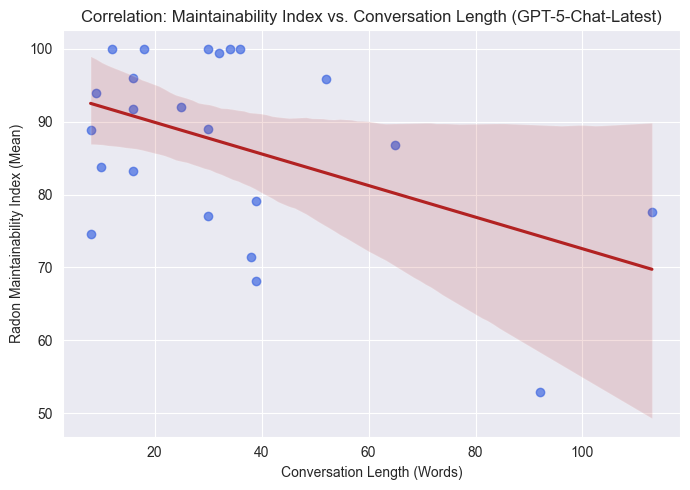

In [55]:
gpt5_df = agg_df[agg_df['model_version'] == 'o3-2025-04-16']
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(
    data=gpt5_df,
    x="length_conversational_words",
    y="mean_radon_maintainability_index",
    scatter_kws={'alpha': 0.7, 'color': 'royalblue'},
    line_kws={'color': 'firebrick'}
)
plt.xlabel("Conversation Length (Words)")
plt.ylabel("Radon Maintainability Index (Mean)")
plt.title("Correlation: Maintainability Index vs. Conversation Length (GPT-5-Chat-Latest)")
plt.tight_layout()
plt.show()


## Average Correlations across models

In [48]:
import pandas as pd
import numpy as np
import pingouin as pg

# model_corrs_dict: dictionary such that
#   key: model name/version (string)
#   value: dataframe with columns ['code_quality_metric', 'prompt_marker', 'correlation', 'p_value']

# 1. Stack all model DataFrames, tagging with model name/version
all_corrs = []
for model, df in model_corrs.items():
    temp = df.copy()
    temp['model'] = model
    all_corrs.append(temp)
all_corrs_df = pd.concat(all_corrs, axis=0, ignore_index=True)

# 2. Group and aggregate across models
def agg_ci(group):
    corrs = group['correlation'].values
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs, ddof=1)
    boot = pg.compute_bootci(corrs, func='mean', n_boot=10000, seed=42)
    ci_low = np.percentile(boot, 2.5)
    ci_high = np.percentile(boot, 97.5)
    return pd.Series({
        'mean': mean_corr,
        'std': std_corr,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

agg_corr_df = (
    all_corrs_df
    .groupby(['code_quality_metric', 'prompt_marker'])
    .apply(agg_ci)
    .reset_index()
)[['code_quality_metric', 'prompt_marker', 'mean', 'std', 'ci_low', 'ci_high']]

agg_corr_df


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_27875/295977364.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_ci)


,code_quality_metric,prompt_marker,mean,std,ci_low,ci_high
0,mean_best_practices_score,informational,-0.054194,0.132388,-0.13550,0.03550
1,mean_best_practices_score,inv_inf,0.058968,0.140385,-0.04525,0.13525
2,mean_best_practices_score,involved,0.016331,0.135797,-0.07525,0.10525
3,mean_best_practices_score,length_conversational_words,-0.228505,0.111052,-0.29625,-0.15375
4,mean_best_practices_score,length_message_text_words,-0.176239,0.083064,-0.22700,-0.11300
...,...,...,...,...,...,...
79,mean_validity_score,involved,0.140137,0.146776,0.03500,0.22500
80,mean_validity_score,length_conversational_words,-0.158979,0.124798,-0.22575,-0.06425
81,mean_validity_score,length_message_text_words,-0.105933,0.088025,-0.16700,-0.05300
82,mean_validity_score,maj_communication_score,-0.022414,0.217575,-0.16250,0.12250


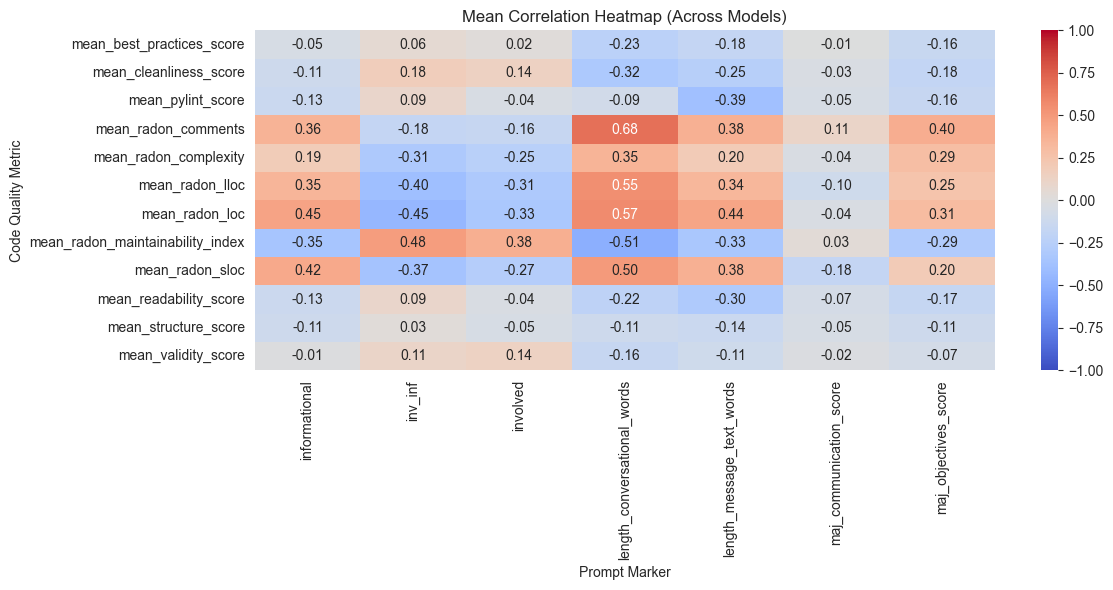

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose agg_df has columns: ['code_quality_metric', 'prompt_marker', 'mean', 'std', 'ci_low', 'ci_high']

# Pivot to matrix for heatmap (rows = code_quality_metric, columns = prompt_marker, values = mean corr)
heatmap_data = agg_corr_df.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,       # show numbers in cells
    fmt=".2f",        # formatting for numbers
    cmap="coolwarm",  # color scheme, you can choose others
    vmin=-1, vmax=1   # set color limits for correlation
)
plt.title("Mean Correlation Heatmap (Across Models)")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample structure
markers = agg_corr_df['prompt_marker'].unique()
metrics = agg_corr_df['code_quality_metric'].unique()

bar_width = 0.8 / len(metrics)   # assume 0.8 is group width (to leave some spacing)

x = np.arange(len(markers))  # the group positions (center of each group)

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    group = agg_corr_df[agg_df['code_quality_metric'] == metric]
    means = group.set_index('prompt_marker').loc[markers]['mean']
    ci_lows = group.set_index('prompt_marker').loc[markers]['ci_low']
    ci_highs = group.set_index('prompt_marker').loc[markers]['ci_high']
    errors = [means - ci_lows, ci_highs - means]
    # plotting the bars at right offset within group
    plt.bar(
        x + i * bar_width,
        means,
        width=bar_width,
        label=metric,
        yerr=errors,
        capsize=5
    )

plt.xticks(x + bar_width * (len(metrics)-1)/2, markers)
plt.xlabel("Prompt Marker")
plt.ylabel("Mean Correlation")
plt.legend(title="Code Quality Metric")
plt.title("Mean Correlation with 95% CIs")
plt.tight_layout()
plt.show()


KeyError: 'code_quality_metric'

<Figure size 1200x600 with 0 Axes>

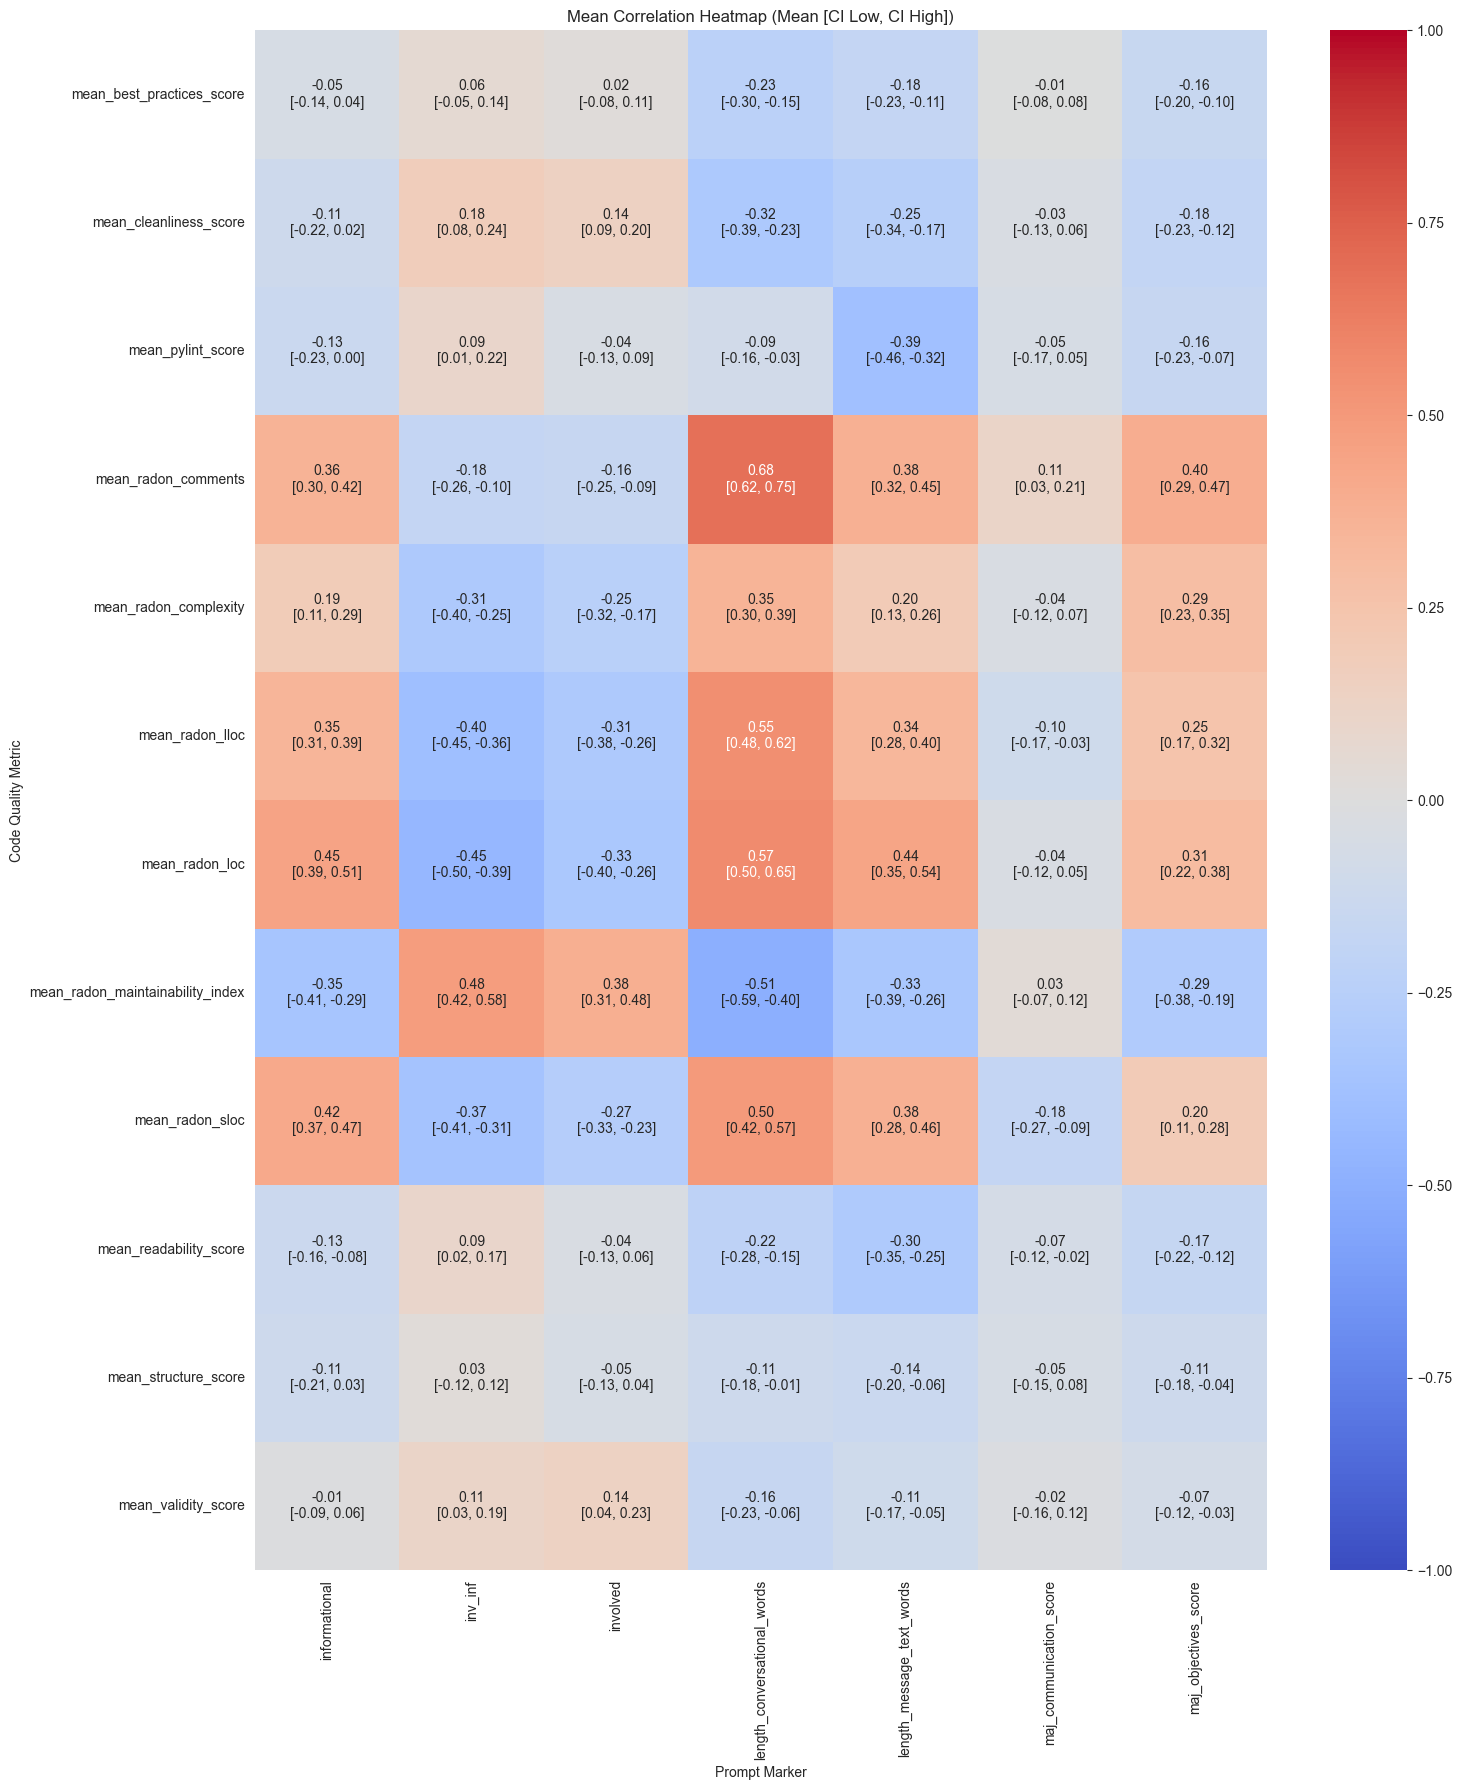

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Pivot for each relevant value
heatmap_mean = agg_corr_df.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')
heatmap_low = agg_corr_df.pivot(index='code_quality_metric', columns='prompt_marker', values='ci_low')
heatmap_high = agg_corr_df.pivot(index='code_quality_metric', columns='prompt_marker', values='ci_high')

# Build annotation text with mean and CI in each cell
annot = heatmap_mean.copy().astype(str)
for i in heatmap_mean.index:
    for j in heatmap_mean.columns:
        m = heatmap_mean.loc[i, j]
        lo = heatmap_low.loc[i, j]
        hi = heatmap_high.loc[i, j]
        annot.loc[i, j] = f"{m:.2f}\n[{lo:.2f}, {hi:.2f}]"

plt.figure(figsize=(len(heatmap_mean.columns)*2.2, len(heatmap_mean.index)*1.5))
sns.heatmap(
    heatmap_mean,
    annot=annot,
    fmt='',
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot_kws={"size": 10}
)
plt.title("Mean Correlation Heatmap (Mean [CI Low, CI High])")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()
